# Using the Snorkel-labeled Dataset for Text Classification
In this notebook, we introduce the _ktrain_ library. _ktrain_ is a Python library that provides a lightweight wrapper for transformer-based models and enables anyone (including someone new to NLP) a gentle introduction to NLP.

To help everyone get started, we will use the Python library _ktrain_ to illustrate how to train a transformer-based model. 

 _ktrain_ enables anyone to get started with using a transformer-based model quickly. _ktrain_ enables us to leverage the pre-trained DistilBert models (available in  HuggingFace) to perform text classification.




In [42]:
# IPython extension to reload modules before executing user code
%reload_ext autoreload
%autoreload 2


## Data Preparation

In [43]:
import pandas as pd

# Read the Fake News Dataset and show the first few rows
# Read the Fake News Dataset and show the first few rows
fakenews_df = pd.read_csv('../data/fakenews_snorkel_labels.csv')
fakenews_df[['id', 'statement','snorkel_labels']].head()


,id,statement,snorkel_labels
0,1248,"During the Reagan era, while productivity incr...",1
1,4518,"""It costs more money to put a person on death ...",1
2,15972,Says that Minnesota Democratic congressional c...,0
3,11165,"""This is the most generous country in the worl...",1
4,14618,"""Loopholes in current law prevent ‘Unaccompani...",0


In [44]:
# In the dataset, you will notice a -1 value in _snorkel_labels_. 
# This is a value set by Snorkel when it is unsure of the label. We will remove rows that have snorkel_values = -1 
fakenews_df = fakenews_df[fakenews_df['snorkel_labels'] >= 0] 

In [45]:
# Next, let us take a look at the unique labels in the dataset. 
# Get the unique labels 
categories = fakenews_df.snorkel_labels.unique()
categories

array([1, 0])

In [46]:
#Let us understand the number of occurrences of real news (1) vs fake news (0). We use the following code to get the _value_counts_ of _fakenews_df['label']_. 
# This helps you understand how the real news vs fake news data is distributed, and whether the dataset is imbalanced.
fakenews_df['snorkel_labels'].value_counts()

1    6287
0    5859
Name: snorkel_labels, dtype: int64

## Getting ready the training and test data
Next, we will split the dataset into training and testing data. We used  _train_test_split_ from _sklearn.model_selection_. The dataset is split into 70% training data and 30% testing data. In addition, we initialize the random generator seed to be 98052. You can set the random generator seed to any value. Having a fixed value for the seed enables the results of your experiment to be reproducible in multiple runs.

In [47]:
# Prepare training and test data
from sklearn.model_selection import train_test_split

# Drop the columns - label and fork 
X = fakenews_df['statement']

# What's in the Readme for the review
print(X.head())

0    During the Reagan era, while productivity incr...
1    "It costs more money to put a person on death ...
2    Says that Minnesota Democratic congressional c...
3    "This is the most generous country in the worl...
4    "Loopholes in current law prevent ‘Unaccompani...
Name: statement, dtype: object


In [48]:
# get the labels
labels = fakenews_df.snorkel_labels

# Split the data into train/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.30, random_state=98052)


In [49]:
# Count of label 0 and 1 in the training data set
print("Rows in X_train %d : " % len(X_train))
type(X_train.values.tolist())

y_train.value_counts()


Rows in X_train 8502 : 


1    4395
0    4107
Name: snorkel_labels, dtype: int64

In [50]:
# Count of label 0 and 1 in the test data set
y_test.value_counts()


1    1892
0    1752
Name: snorkel_labels, dtype: int64

## Dealing with an Imbalanced Dataset
While the data distribution for this current dataset does not indicate an imbalanced dataset, we included a section on how to deal with the imbalanced dataset, that we hope will be useful with you in future experiments where you have to deal with one.

In many real-world cases, the dataset is imbalanced. That is, there are more instances of one class (majority class), than the other class  (minority class). In this section, we show how you can deal with class imbalance.

There are different approaches to dealing with the imbalanced dataset. One of the commonly used technique is resampling. In resampling, the data from the majority class are under-sampled, and the data from the minority class are over-sampled. In this way, you get a balanced dataset that has equal occurrences of both classes. 

In [51]:
# Getting the dataset ready for using RandomUnderSampler
import numpy as np

X_train_np = X_train.to_numpy()
X_test_np =  X_test.to_numpy()

# Convert 1D to 2D (used as input to sampler)
X_train_np2D = np.reshape(X_train_np,(-1,1))
X_test_np2D = np.reshape(X_test_np,(-1,1))

In [52]:
# Once the data is in the expected shape, we use  _RandomUnderSampler_ to perform under-sampling of the training dataset.
from imblearn.under_sampling import RandomUnderSampler

# Perform random under-sampling
sampler = RandomUnderSampler(random_state = 98053)
X_train_rus, Y_train_rus = sampler.fit_resample(X_train_np2D, y_train)
X_test_rus, Y_test_rus = sampler.fit_resample(X_test_np2D, y_test)



In [53]:
from collections import Counter

print('Resampled Training dataset  %s' % Counter(Y_train_rus))
print('Resampled Test dataset %s' % Counter(Y_test_rus))

Resampled Training dataset  Counter({0: 4107, 1: 4107})
Resampled Test dataset Counter({0: 1752, 1: 1752})


In [54]:
# Preparing the resampled datasets
# flatten train and test dataset 
X_train_rus = X_train_rus.flatten()
X_test_rus = X_test_rus.flatten()


## Training the model using ktrain
We will be using _ktrain_ to train the text classification model. https://github.com/amaiya/ktrain[ktrain] provides a lightweight _Tensorflow Keras_ wrapper that empowers any data scientist to quickly train various deep learning models (text, vision, and many more). From version v0.8 onwards, _ktrain_ has also added support for Hugging Face transformers.


In [55]:
import ktrain
from ktrain import text

model_name = 'distilbert-base-uncased'
t = text.Transformer(model_name, class_names=labels.unique(), maxlen=500)


### Pre-processing for training and test data

In [56]:
# Once the model has been loaded,  we use _t.preprocess_train()_ and _t.preprocess_test()_ to process both the training and testing data.
train = t.preprocess_train(X_train_rus.tolist(), Y_train_rus.to_list())



preprocessing train...
language: en
train sequence lengths:
	mean : 18
	95percentile : 34
	99percentile : 43


In [57]:
val = t.preprocess_test(X_test_rus.tolist(), Y_test_rus.to_list())


preprocessing test...
language: en
test sequence lengths:
	mean : 18
	95percentile : 34
	99percentile : 44


Once we have pre-processed both training and test datasets, we are ready to train the model. First, we retrieve the classifier and store it in the _model_ variable. 

In the https://github.com/google-research/bert[BERT paper], the authors selected the best fine-tuning hyperparameters from various batch sizes: 8, 16, 32, 64, 128, and learning rate ranging from 3e-4, 1e-4, 5e-5, 3e-5 and trained the model for 4 epochs.

For this exercise, we use a batch_size of 8, and a learning rate of 3e-5, and trained for 3 epochs. These values are chosen based on common defaults used in many papers. The number of epochs was set to 3 to prevent overfitting.


### Using ktrain to fine-tune the model

In [58]:
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=8)

learner.fit_onecycle(3e-5, 3)

                            



begin training using onecycle policy with max lr of 3e-05...
Epoch 1/3
1027/1027 [==============================] - 928s 895ms/step - loss: 0.6680 - accuracy: 0.5785 - val_loss: 0.6253 - val_accuracy: 0.6438
Epoch 2/3
1027/1027 [==============================] - 919s 893ms/step - loss: 0.5747 - accuracy: 0.7044 - val_loss: 0.6300 - val_accuracy: 0.6638
Epoch 3/3
1027/1027 [==============================] - 921s 896ms/step - loss: 0.3696 - accuracy: 0.8368 - val_loss: 0.7176 - val_accuracy: 0.6741


In [59]:
learner.validate(class_names=t.get_classes())

              precision    recall  f1-score   support

           1       0.70      0.62      0.66      1752
           0       0.66      0.73      0.69      1752

    accuracy                           0.67      3504
   macro avg       0.68      0.67      0.67      3504
weighted avg       0.68      0.67      0.67      3504



array([[1086,  666],
       [ 476, 1276]])

In [60]:
# show the top 3 rows where the model made mistakes
learner.view_top_losses(n=3, preproc=t)

----------
id:3495 | loss:5.2 | true:0 | pred:1)

----------
id:2289 | loss:5.15 | true:0 | pred:1)

----------
id:3188 | loss:5.05 | true:0 | pred:1)



In [61]:
# Show the readme for the entry where we made mistakes
# We predicted GENERAL, when this should be predicted as API
# Note: This is based on the quality of the hand-labeling and weak labels
# This example is used for demonstration purpose only.
print("Ground truth: %d" % Y_test_rus[2826])
print("-------------")

# this was predicted as 1 when it should be a 0
# Ground truth indicates that this is API
print(X_test_rus[2826])


Ground truth: 1
-------------
"Tim Kaine announced he wants to raise taxes on everyone."


### Finding a good learning rate
It is important to find a good learning rate before you start training the model.

_ktrain_ provides the _lr_find()_ function for finding a good learning rate.
 _lr_find()_ outputs the plot that shows the loss vs the learning rate (expressed in a logarithmic scale).

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
1026/1026 [==============================] - 897s 872ms/step - loss: 0.1992 - accuracy: 0.9340
Epoch 2/5
1026/1026 [==============================] - 897s 874ms/step - loss: 0.2701 - accuracy: 0.8864
Epoch 3/5
1026/1026 [==============================] - 17s 16ms/step - loss: 0.4501 - accuracy: 0.7817


done.
Visually inspect loss plot and select learning rate associated with falling loss


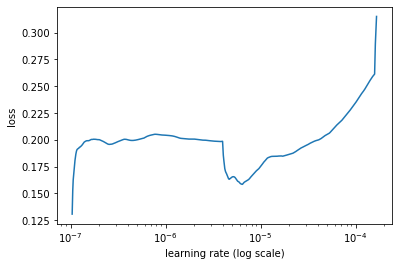

In [62]:
# Find a good learning rate 
# The results from lr_find are visualized, where the x-axis is the learning rate (log scale) and y-axis is the loss
# Using lr_find, you will see the loss stopps decreasing, and starts to increase
# In general, will be good to pick a learning rate near the lowest point of the graph
learner.lr_find(show_plot=True, max_epochs=5)

## Using the fine-tuned model for prediction


In [64]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [65]:
# Src: # https://www.cnn.com/2020/11/07/business/business-leaders-react-biden-win/index.html
news_txt = '"Now is a time for unity. We must respect the results of the U.S. presidential election and, as we have with every election, honor the decision of the voters and support a peaceful transition of power," said Jamie Dimon, CEO of JPMorgan Chase .'

In [68]:
predictor.predict(news_txt)

1

In [69]:
# Before running this, install the following eli5
# pip install git+https://github.com/amaiya/eli5@tfkeras_0_10_1
predictor.explain(news_txt)